In [1]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

# Demand function

In [2]:
@jit(nopython=True)
def Demand(p1, p2):
    if p1 < p2:
        return (1 - p1)
    elif p1 > p2:
        return 0
    else:
        return (0.5 * (1 - p1))

# Profit function

In [3]:
@jit(nopython=True)
def Profit(p1, p2):
    return (p1 * Demand(p1, p2))

In [4]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Q-learning and simulation function

In [5]:
@jit(nopython=True)
def Qfunction(price, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price1 = int(np.random.choice(len(price))) # index i matrix kan ikke være en float
    price2 = 0

    price1_list = []
    price2_list = []

    price1_list.append(price1)
    price1_list.append(price1)
    price2_list.append(price2)
    price2_list.append(price2)

    state = 0

    Qtable_1 = np.zeros((len(price), len(price)))
    Qtable_2 = np.zeros((len(price), len(price)))

    profit_1_list = [] # kan måske slettes senere
    profit_2_list = [] # kan måske slettes senere

    avg_profit_1 = 0
    avg_profit_2 = 0

    profit_1_list.append(avg_profit_1)
    profit_1_list.append(avg_profit_1)
    profit_2_list.append(avg_profit_2)
    profit_2_list.append(avg_profit_2)


    t = 3
    i = 1
    j = 2

    for t in range(t, period + 1):
        epsilon = (1 - theta)**t
        #print("t = ", t)
        if (t % 2) != 0:
            #print("Firm 1\n")

            # Previous estimate
            prev_estimate = Qtable_1[price1, price2]
            #print("price1:\n", price1)
            #print("price2:\n", price2)
            #print("prev_estimate:\n", prev_estimate)

            # New estimate
            profit_current_state = Profit(price[price1], price[price2])
            #print("profit_current_state:\n", profit_current_state)

            profit_next_state = delta * Profit(price[price1], price[state])
            #print("state:\n", state)
            #print("profit_next_state:\n", profit_next_state)

            max_Q = np.argmax(Qtable_1[:, state])
            #print("Qtable_1:\n", Qtable_1[:, state])
            #print("Max_Q:\n", max_Q)

            max_Q_next_state = delta**2 * max_Q
            #print("max_Q_next_state:\n", max_Q_next_state)

            new_estimate = profit_current_state + profit_next_state + max_Q_next_state
            #print("new_estimate:\n", new_estimate)

            # Update
            Qtable_1[price1, price2] = (1 - alpha) * prev_estimate + alpha * new_estimate
            #print("Qtable_1:\n", Qtable_1)

            # Set p_it
            if np.random.uniform(0,1) < epsilon:
                price1 = int(np.random.choice(len(price)))
                #print("Random\n")
            else:
                state = price2
                #print("state:", state)
                price1 = np.argmax(Qtable_1[:, state])
                #print("Max\n")
            
            #print("pris1:\n", price1)

            state = price1
            #print("state:", state)

            price1_list.append(price[price1])
            price1_list.append(price[price1])
            profit_1_list.append(profit_current_state)
            profit_1_list.append(profit_current_state)

            if t >= (period + 1) - 1000:
                avg_profit_1 +=profit_current_state
            #print("1", price1_list)

        else:
            #print("Firm 2\n")
            # Previous estimate
            prev_estimate = Qtable_2[price2, state]
            #print("price2:\n", price2)
            #print("state:\n", state)
            #print("prev_estimate:\n", prev_estimate)

            # New estimate
            profit_current_state = Profit(price[price2], price[price1])
            #print("price1:\n", price1)
            #print("profit_current_state:\n", profit_current_state)

            profit_next_state = delta * Profit(price[price2], price[state])
            #print("profit_next_state:\n", profit_next_state)

            max_Q = np.argmax(Qtable_2[:, state])
            #print("Qtable_2:\n", Qtable_2[:, state])
            #print("Max_Q:\n", max_Q)

            max_Q_next_state = delta**2 * max_Q
            #print("max_Q_next_state:\n", max_Q_next_state)

            new_estimate = profit_current_state + profit_next_state + max_Q_next_state
            #print("new_estimate:\n", new_estimate)

            # Update
            Qtable_2[price2, state] = (1 - alpha) * prev_estimate + alpha * new_estimate 
            #print("Qtable_2:\n", Qtable_2)

            # Set p_jt
            if np.random.uniform(0,1) < epsilon:
                price2 = int(np.random.choice(len(price)))
                #print("Random:\n")
            else:
                state = price1
                #print("state:", state)
                price2 = np.argmax(Qtable_2[:, state])
                #print("Max\n")
            #print("pris2:\n", price2)


            state = price2
            #print("state:", state)

            price2_list.append(price[price2])
            price2_list.append(price[price2])
            profit_2_list.append(profit_current_state)
            profit_2_list.append(profit_current_state)

            if t >= (period + 1) - 1000:
                avg_profit_2 +=profit_current_state
            #print("2", price2_list)

        # Update t, i and j
        t = t + 1
        i = j
        j = i

        Final_profit_1 = avg_profit_1/500 # måske 1000
        Final_profit_2 = avg_profit_2/500 # måske 1000
   
    return Qtable_1, Qtable_2, price1_list, price2_list, profit_1_list, profit_2_list, Final_profit_1, Final_profit_2

@jit(nopython=True)
def Simulations(sim, price, period, delta, alpha, theta):
    # Qtable1_list = []
    # Qtable2_list = []
    all_price1 = np.zeros((sim, period))
    all_price2 = np.zeros((sim, period))
    all_profit1 = np.zeros((sim, period))
    all_profit2 = np.zeros((sim, period)) 
    final_profit1_list = []
    final_profit2_list = []

    for i in range(sim):
        _, _, all_price1[i, :], all_price2[i, :], all_profit1[i, :], all_profit2[i, :], final_profit_1, final_profit_2 = Qfunction(price, period, delta, alpha, theta)
        # Qtable1_list.append(Qtable1)
        # Qtable2_list.append(Qtable2)
        final_profit1_list.append(final_profit_1)
        final_profit2_list.append(final_profit_2)

    return all_price1, all_price2, all_profit1, all_profit2, final_profit1_list, final_profit2_list

# Time calculation for 1000 simulations

In [6]:
start_time  = time.time()

np.random.seed(387)
all_p1, all_p2, all_profit1, all_profit2, final_avg_profit1, final_avg_profit2 = Simulations(1000, P, 500000, 0.95, 0.3, 0.0000276306)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 34.2498619556427 seconds


In [ ]:
all_price1_array = np.array(all_p1)
all_price2_array = np.array(all_p2)

all_profit1_array = np.array(all_profit1)
all_profit2_array = np.array(all_profit2)
        
# Calculate the average profit and price for each period across all simulations
avg_price1 = np.mean(all_price1_array, axis=0)
avg_price2 = np.mean(all_price2_array, axis=0)
avg_profit1 = np.mean(all_profit1_array, axis=0)
avg_profit2 = np.mean(all_profit2_array, axis=0)

# Plotting

1000


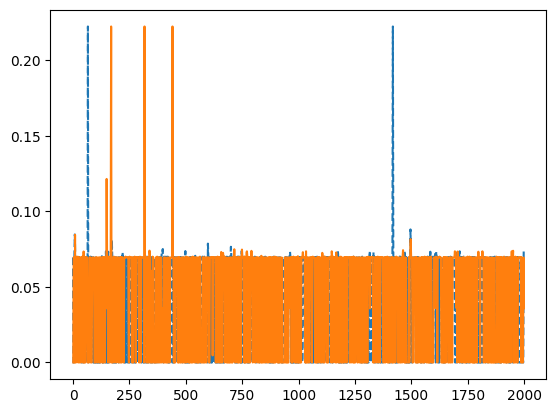

In [161]:

Time_1 = np.arange(0, 1999, 2)
Time_2 = np.arange(1, 2000, 2)
Time_T = np.arange(500000)
print(len(avg_profit2))


X = np.linspace(0, Time_1)
x2 = np.arange(0, 249999)
Y = p1    


plt.plot(Time_1, final_avg_profit1, label = 'P1', linestyle='--')
plt.plot(Time_2, final_avg_profit2, label = 'P2', linestyle='-')

plt.show()
